In [1]:
# Standard library
import os
import sys
import warnings

# adjust path and suppress warnings
sys.path.insert(0, os.path.abspath('..'))
warnings.filterwarnings('ignore')

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import healpy as hp

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table

from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree

# Local
import util
import utils


In [2]:
size_ratio = 1
sub_width, sub_height = size_ratio*10/3, size_ratio*2.8
SMALL_SIZE = 7
MEDIUM_SIZE = 9
BIGGER_SIZE = 10


rc_default = {}
rc_default['font.family'] = 'serif'
rc_default['font.size'] = SMALL_SIZE
rc_default['axes.labelsize'] = MEDIUM_SIZE
rc_default['axes.labelweight'] = 'normal'
rc_default['axes.linewidth'] = 1.0
rc_default['axes.titlesize'] = MEDIUM_SIZE
rc_default['xtick.labelsize'] = SMALL_SIZE
rc_default['ytick.labelsize'] = SMALL_SIZE
rc_default['legend.fontsize'] = SMALL_SIZE
rc_default['figure.titlesize'] = BIGGER_SIZE
rc_default['lines.linewidth'] = 1
rc_default['lines.markersize'] = 4
rc_default['figure.figsize'] = (sub_width, sub_height)
rc_default['savefig.dpi'] = 400

# Latex related
rc_default['text.usetex'] = True
rc_default['mathtext.fontset'] = 'custom'
rc_default['mathtext.rm'] = 'Bitstream Vera Sans'
rc_default['mathtext.it'] = 'Bitstream Vera Sans:italic'
rc_default['mathtext.bf'] = 'Bitstream Vera Sans:bold'

plt.rcParams.update(rc_default)
plt.style.use('tableau-colorblind10')

In [3]:
Legacy_BG_path = "/its/home/bb345/5-4most_data/CRS/target_catalogues/BG/full_legacy_no_colour_sel/.archive/reduced/desi_bg_nomaskbit_mask_4M_reduced_columns.fits"

In [4]:
Gaia_path = "/its/home/bb345/5-4most_data/other_data/gaia_sources/gaia-mask-dr10_bg_foot.fits"

In [5]:
BG = Table.read(Legacy_BG_path)

In [6]:
gaia = Table.read(Gaia_path)

In [7]:
BG = BG.to_pandas()

In [11]:
BG = BG[BG.isBG_4M_v2]

In [ ]:
BG

,OBJID,RA,DEC,EBV,WISEMASK_W1,MASKBITS,isBG_4M,in_S8,in_DESI_DR1,mag_r,mag_z,mag_g,mag_i,mag_w1,isBG_4M_v2,desi_bgs_selection,galactic_cap,dr1_bg_mask
4,1219,157.028158,-2.272059,0.041179,0,0,True,False,True,18.530964,17.854332,19.707085,18.141018,17.936350,True,True,b'NGC',True
5,1576,157.035500,-2.270895,0.041186,0,0,True,False,True,18.154840,17.266401,19.582981,17.617146,16.646183,True,True,b'NGC',True
17,3463,157.078496,-2.132005,0.044005,0,0,True,False,True,18.284254,17.519909,19.758774,17.798515,17.251682,True,True,b'NGC',True
18,3745,157.084891,-2.167143,0.043157,0,0,True,False,True,18.479233,17.673344,19.868189,17.985254,17.257504,True,True,b'NGC',True
22,4712,157.105712,-2.330024,0.040446,0,0,False,False,True,19.159546,18.426689,20.465088,18.729229,18.386234,True,True,b'NGC',True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16742599,5810,144.798849,-5.314694,0.031073,0,0,False,False,True,19.037411,18.180340,20.642546,18.481697,17.805439,True,True,b'NGC',True
16742601,5878,144.800491,-5.198375,0.037407,0,0,False,False,True,19.102072,18.207945,20.844877,18.519903,17.744095,True,True,b'NGC',True
16742610,7637,144.842947,-5.309484,0.033186,0,0,True,False,True,18.839581,18.109055,20.154453,18.394375,17.980824,True,True,b'NGC',True
16742612,8023,144.852548,-5.135250,0.038222,0,0,True,False,True,18.828699,18.063553,20.319115,18.370508,17.842636,True,True,b'NGC',True


In [ ]:
LRG

,OBJID,RA,DEC,EBV,WISEMASK_W1,PSFSIZE_G,PSFSIZE_R,PSFSIZE_I,PSFSIZE_Z,PSFDEPTH_G,...,Z_PHOT_STD,isLRG_4M,in_S8,in_DESI_DR1,mag_r,mag_z,mag_w1,mag_g,mag_fiberz,galactic_cap
0,531,334.194556,-45.331501,0.021752,0,1.613177,1.342430,1.177746,1.325987,4547.411621,...,0.052715,True,True,False,20.779900,19.772301,18.298798,22.118931,20.681299,b'SGC'
1,636,334.197982,-45.323136,0.021372,0,1.613177,1.354094,1.158701,1.323976,4547.411621,...,0.039985,True,True,False,21.875097,20.341349,18.723869,23.720015,21.460213,b'SGC'
2,692,334.199300,-45.340498,0.021901,0,1.580269,1.369656,1.177746,1.390829,4792.001953,...,0.038514,True,True,False,20.580793,19.457472,18.275036,21.720421,21.003563,b'SGC'
3,1133,334.213916,-45.355311,0.021866,0,1.557396,1.302155,1.156571,1.327200,4553.250977,...,0.032469,True,True,False,21.124153,19.391083,17.858835,22.997175,20.860195,b'SGC'
4,1177,334.215258,-45.244027,0.018549,0,1.612500,1.353601,1.150843,1.321957,4498.503906,...,0.059779,True,True,False,22.049360,20.385891,18.493507,23.487206,21.472549,b'SGC'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10165877,7802,280.087826,-53.000011,0.080092,0,1.777501,1.775850,0.000000,1.417919,39.051941,...,0.142027,True,False,False,20.427456,19.333546,17.858925,21.920816,21.454433,b'SGC'
10165878,7907,280.091932,-53.055919,0.081667,0,1.823599,1.782116,1.271033,1.417919,334.816681,...,0.014762,True,False,False,18.665874,17.798912,17.295233,20.335766,19.010603,b'SGC'
10165879,7909,280.091964,-53.064687,0.082129,0,1.823599,1.786644,1.271033,1.417919,334.816681,...,0.021562,True,False,False,18.859930,17.952497,17.481071,20.581816,19.426792,b'SGC'
10165880,8048,280.097764,-52.955797,0.078708,0,1.809464,1.758398,0.000000,1.442846,360.970947,...,0.139892,True,False,False,21.647644,20.509701,18.286884,23.207256,21.146503,b'SGC'


In [8]:
gaia = gaia.to_pandas()

In [9]:
gaia.columns

Index(['RA', 'DEC', 'G', 'R_medium_arcsec', 'R_bright_arcsec', 'isbright',
       'ismedium'],
      dtype='object')

In [10]:
bg = BG

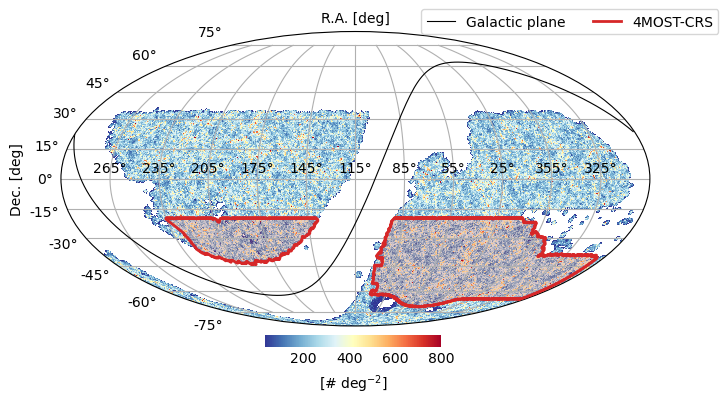

In [ ]:
hpmap = utils.create_hp_map(BG['RA'], BG['DEC'], nside=128)
utils.plot_moll(hpmap, rot=115, min=30, max=800, fourmost_footprint=True)

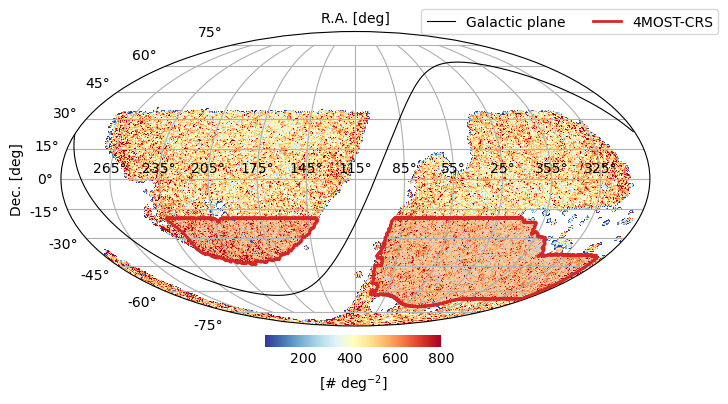

In [ ]:
hpmap = utils.create_hp_map(LRG['RA'], LRG['DEC'], nside=128)
utils.plot_moll_behnood(hpmap, rot=115, min=30, max=800, fourmost_footprint=True)

In [ ]:
gaia_ra = gaia['RA'].values        # numpy array of RA in deg
gaia_dec = gaia['DEC'].values      # Dec in deg
gaia_mag = gaia['G'].values
gaia_Rmed = gaia['R_medium_arcsec'].values  # in arcsec

bg_ra = bg['RA'].values   # deg
bg_dec = bg['DEC'].values # deg

lrg_ra = LRG['RA'].values   # deg
lrg_dec = LRG['DEC'].values # deg

In [ ]:
# Create SkyCoord objects for all Gaia stars and BG sources
gaia_coords = SkyCoord(gaia_ra * u.deg, gaia_dec * u.deg, frame='icrs')
bg_coords   = SkyCoord(bg_ra * u.deg, bg_dec * u.deg, frame='icrs')
lrg_coords  = SkyCoord(lrg_ra * u.deg, lrg_dec * u.deg, frame='icrs')

In [ ]:
Gmin, Gmax = 8, 16

In [ ]:
sel = (gaia_mag > Gmin) & (gaia_mag < Gmax)
gaia_coords = gaia_coords[sel]

In [ ]:
R = 0.05 * u.rad

In [ ]:
# --- your existing bins & setup ---
mag_bins = [(8, 12), (12, 13), (13, 15), (15, 16)]
nbins    = 150
r_extent = 4.0
annulus  = (1.1, 3.0)
dr       = 1

# --- placeholder functions: replace with the real DR8/DR9 formulas ---
def mask_radius_DR9(g):
    # DR9 bright‐star mask radius [arcsec] as a function of G-mag
    # e.g. piecewise interpolation from Legacy Surveys DR9 prescription.
    # Here’s a toy example:
    return  10**(0.2*(13 - g))

def mask_radius_DR8(g):
    # DR8 bright‐star mask radius [arcsec] as a function of G-mag
    # e.g. a different piecewise curve published for DR8.
    # Here’s a toy example that’s ~1.7× larger than DR9:
    return 2 * mask_radius_DR9(g)

def mask_radius_for_mag(mag):
    # Returns a masking radius in degrees for a star of the given magnitude.
    # Used for Tycho-2 and Gaia stars.

    # This is in degrees, and is from Rongpu in the thread [decam-chatter 12099].
    return 0.5*1630. * 1.396**(-mag)
# --- build BG SkyCoord once ---
cats = SkyCoord(ra=BG['RA'].values*u.deg,
                dec=BG['DEC'].values*u.deg)

In [ ]:
import numpy as np
import pandas as pd
import healpy as hp
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def mask_radius_DR9(g):
    """
    DR9 bright-star mask radius [arcmin] as a function of G-mag.
    Original implementation for DR9.
    """
    g = np.asarray(g)
    r = np.zeros_like(g, dtype=float)
    mask1 = (g > 3.5) & (g < 16)
    mask2 = g <= 3.5
    r[mask1] = (10 ** (1.3 - 0.13 * g[mask1]))
    r[mask2] = 7
    return r


def mask_radius_DR8(g):
    """
    DR8 bright-star mask radius [arcmin] ~1.7× larger than DR9 (toy example).
    """
    return 2 * mask_radius_DR9(g)


def mask_radius_for_mag(mag):
    """
    Reference mask radius [degrees] for a star of given magnitude,
    from Rongpu (decam-chatter 12099).
    """
    mag = np.asarray(mag)
    return 0.5 * 1630. * 1.396 ** (-mag)


class StarOverdensities:
    def __init__(
        self,
        galaxies_df: pd.DataFrame = None,
        gaia_df: pd.DataFrame = None,
        galaxies_filepath: str = None,
        gaia_filepath: str = None,
        region: str = 'S',
        gaia_g_bins=[[0, 8], [8, 13], [13, 15], [15, 16]],
        galaxy_ra_col: str = 'RA',
        galaxy_dec_col: str = 'DEC',
        star_ra_col: str = 'RA',
        star_dec_col: str = 'DEC',
        star_mag_col: str = 'G',
        nside: int = 1024 * 32,
        extent: float = 3.0
    ):
        self.galaxies_df = galaxies_df
        self.gaia_df = gaia_df
        self.galaxies_filepath = galaxies_filepath
        self.gaia_filepath = gaia_filepath
        self.region = region
        if self.region not in ['N', 'S']:
            raise ValueError(r"region must be 'N' or 'S'")

        self.gaia_bins = gaia_g_bins
        self.bin_names = [f"{b[0]}<G<{b[1]}" for b in self.gaia_bins]
        print(rf"bin names: {self.bin_names}")

        self.galaxy_ra_col = galaxy_ra_col
        self.galaxy_dec_col = galaxy_dec_col
        self.star_ra_col = star_ra_col
        self.star_dec_col = star_dec_col
        self.star_mag_col = star_mag_col

        self.stacks = {}
        self.bin_edges = {}
        self.nside = nside
        self.extent = extent
        self.region_pix = None

    def load_galaxies(self):
        r"""Load galaxy catalog and derive healpix region based on file extension."""
        if self.galaxies_df is not None:
            df = self.galaxies_df.copy()
        elif self.galaxies_filepath:
            fp = self.galaxies_filepath
            ext = fp.lower().split('.')[-1]
            if ext == 'parquet':
                import pyarrow.parquet as pq
                df = pq.read_table(fp).to_pandas()
            elif ext == 'csv':
                df = pd.read_csv(fp)
            elif ext in ('fits', 'fit'):
                tbl = Table.read(fp)
                df = tbl.to_pandas()
            else:
                raise ValueError(rf"Unsupported galaxy file format: .{ext}")
        else:
            raise ValueError(r"Provide either galaxies_df or galaxies_filepath")
        if 'duplicate' in df.columns:
            df = df[df['duplicate'] == 0]
        self.cat = df

        coords = SkyCoord(
            ra=self.cat[self.galaxy_ra_col].values * u.deg,
            dec=self.cat[self.galaxy_dec_col].values * u.deg
        )
        ra_rad = coords.ra.rad
        dec_rad = coords.dec.rad
        ipix_gal = hp.ang2pix(self.nside, 0.5 * np.pi - dec_rad, ra_rad)
        self.region_pix = set(ipix_gal)
        print(rf"Derived region with {len(self.region_pix)} healpix pixels from galaxy catalog.")

    def load_gaia_stars(self):
        r"""Load Gaia stars, filter by mag/region, compute mask radii based on file extension."""
        if self.gaia_df is not None:
            df = self.gaia_df.copy()
        elif self.gaia_filepath:
            fp = self.gaia_filepath
            ext = fp.lower().split('.')[-1]
            if ext == 'parquet':
                import pyarrow.parquet as pq
                df = pq.read_table(fp).to_pandas()
            elif ext == 'csv':
                df = pd.read_csv(fp)
            elif ext in ('fits', 'fit'):
                tbl = Table.read(fp)
                df = tbl.to_pandas()
            else:
                raise ValueError(rf"Unsupported Gaia file format: .{ext}")
        else:
            raise ValueError(r"Provide either gaia_df or gaia_filepath")
        df = df[df[self.star_mag_col] <= 16]
        if self.region == 'S':
            df = df[df[self.star_dec_col] < -10]
        else:
            df = df[df[self.star_dec_col] > -10]
        df['mask_radius_arcmin'] = mask_radius_DR9(df[self.star_mag_col])
        self.all_stars = df

    def get_stacks(self):
        r"""Compute density stacks of galaxies around each Gaia star bin."""
        if self.region_pix is None:
            raise RuntimeError(r"Call load_galaxies() before get_stacks()")
        coords_gal = SkyCoord(
            ra=self.cat[self.galaxy_ra_col].values * u.deg,
            dec=self.cat[self.galaxy_dec_col].values * u.deg
        )
        ra_rad = coords_gal.ra.rad
        dec_rad = coords_gal.dec.rad
        ipix_sources = hp.ang2pix(self.nside, 0.5 * np.pi - dec_rad, ra_rad)
        mask = np.isin(ipix_sources, list(self.region_pix))
        ipix_sources = ipix_sources[mask]
        density_map = Counter(ipix_sources)

        min_radius = self.all_stars['mask_radius_arcmin'].min()
        res_arcmin = hp.nside2resol(self.nside, arcmin=True)
        nbins = int(np.floor(self.extent * min_radius / res_arcmin))
        self.nbins = nbins
        self.xedges = np.linspace(-self.extent, self.extent, nbins + 1)
        self.yedges = np.linspace(-self.extent, self.extent, nbins + 1)

        rad_to_arcmin = 180 / np.pi * 60
        query_extent = 5

        for gbin, bin_name in enumerate(self.bin_names):
            sel = (
                (self.all_stars[self.star_mag_col] > self.gaia_bins[gbin][0]) &
                (self.all_stars[self.star_mag_col] <= self.gaia_bins[gbin][1])
            )
            stars = self.all_stars[sel]
            coords_star = SkyCoord(
                ra=stars[self.star_ra_col].values * u.deg,
                dec=stars[self.star_dec_col].values * u.deg
            )
            radii = stars['mask_radius_arcmin'].values

            xedges = np.linspace(-self.extent, self.extent, int(np.floor(self.extent * radii.min() / res_arcmin)) + 1)
            yedges = np.linspace(-self.extent, self.extent, int(np.floor(self.extent * radii.min() / res_arcmin)) + 1)
            self.bin_edges[bin_name] = (xedges, yedges)
            self.stacks[bin_name] = np.zeros((len(yedges)-1, len(xedges)-1), dtype=np.float32)

            for i in tqdm(range(len(stars)), desc=rf"Stacking {bin_name}"):
                ra0 = coords_star.ra.rad[i]
                dec0 = coords_star.dec.rad[i]
                R_arcmin = radii[i]
                R_deg = R_arcmin * query_extent / 60.0
                vec = hp.ang2vec(0.5 * np.pi - dec0, ra0)
                ipix_disc = hp.query_disc(self.nside, vec, np.radians(R_deg), inclusive=True)
                for ipix in ipix_disc:
                    if ipix not in density_map:
                        continue
                    theta, phi = hp.pix2ang(self.nside, ipix)
                    ra_pix = phi
                    dec_pix = 0.5 * np.pi - theta
                    dra = (ra_pix - ra0) * np.cos(dec0)
                    ddec = dec_pix - dec0
                    x = dra * rad_to_arcmin / R_arcmin
                    y = ddec * rad_to_arcmin / R_arcmin
                    if abs(x) < self.extent and abs(y) < self.extent:
                        ix = np.searchsorted(xedges, x) - 1
                        iy = np.searchsorted(yedges, y) - 1
                        if 0 <= ix < self.stacks[bin_name].shape[1] and 0 <= iy < self.stacks[bin_name].shape[0]:
                            self.stacks[bin_name][iy, ix] += density_map[ipix]

    def plot_stacks(self):
        r"""Visualize the stacked density around stars for each magnitude bin."""
        n_bins = len(self.stacks)
        if n_bins <= 2:
            fig, axes = plt.subplots(1, n_bins, figsize=(6 * n_bins, 6))
        elif n_bins <= 4:
            fig, axes = plt.subplots(2, 2, figsize=(12, 12))
        else:
            n_rows = (n_bins + 2) // 3
            fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6 * n_rows))
        if n_bins == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        for i, (bin_name, stacked) in enumerate(self.stacks.items()):
            ax = axes[i]
            xedges, yedges = self.bin_edges[bin_name]
            mean_density = np.mean(stacked[stacked > 0]) if np.any(stacked > 0) else 0
            if mean_density > 0:
                log_density = np.log(stacked / mean_density)
                log_density[np.isinf(log_density)] = np.nanmin(log_density)
            else:
                log_density = np.zeros_like(stacked)
            vmax = np.nanmax(np.abs(log_density)) or 1.0
            pcm = ax.pcolormesh(xedges, yedges, log_density,
                                cmap='seismic', shading='flat',
                                vmin=-vmax, vmax=vmax)
            ax.set_xlabel(r'$\Delta\mathrm{RA} / R_{\mathrm{mask}}$')
            ax.set_ylabel(r'$\Delta\mathrm{Dec} / R_{\mathrm{mask}}$')
            ax.set_title(rf'Density around stars {bin_name}')
            ax.set_xlim(-self.extent, self.extent)
            ax.set_ylim(-self.extent, self.extent)
            ax.set_aspect('equal')
            circle = patches.Circle((0, 0), 1, fill=False, color='black', linewidth=2)
            ax.add_patch(circle)
            cbar = plt.colorbar(pcm, ax=ax)
            cbar.set_label(r'$\log(\rho/\bar{\rho})$')
            ax.grid(alpha=0.3, linestyle=':')
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)
        plt.tight_layout()
        plt.show()

    def plot_mask_radius_comparison(self, mag_min=3.5, mag_max=16.0, npts=200):
        r"""Plot DR9 and DR8 mask radii normalized by the reference mask_radius_for_mag."""
        mags = np.linspace(mag_min, mag_max, npts)
        r_dr9 = mask_radius_DR9(mags)
        r_dr8 = mask_radius_DR8(mags)
        r_ref_deg = mask_radius_for_mag(mags)
        r_ref_arcmin = r_ref_deg * 60.0

        ratio_dr9 = r_dr9 / r_ref_arcmin
        ratio_dr8 = r_dr8 / r_ref_arcmin

        plt.figure(figsize=(8, 5))
        plt.plot(mags, ratio_dr9, label=r'DR9 / ref')
        plt.plot(mags, ratio_dr8, label=r'DR8 / ref')
        plt.axhline(1.0, color='gray', linestyle='--')
        plt.xlabel(r'$G\ \mathrm{mag}$')
        plt.ylabel(r'\mathrm{Mask\ radius}\ /\ \mathrm{reference}$')
        plt.title(r'\mathrm{Normalized\ Mask\ Radius\ Comparison}$')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()




In [ ]:
if __name__ == "__main__":
    analyzer = StarOverdensities(
        galaxies_df=bg,
        gaia_df=gaia,
        
    )
    print(r"Loading galaxy catalog...")
    analyzer.load_galaxies()
    print(r"Loading Gaia stars...")
    analyzer.load_gaia_stars()
    print(r"Calculating stacks...")
    analyzer.get_stacks()
    print(r"Plotting results...")
    analyzer.plot_stacks()
    print(r"Plotting mask radius comparison...")
    analyzer.plot_mask_radius_comparison()

bin names: ['0<G<8', '8<G<13', '13<G<15', '15<G<16']
Loading galaxy catalog...
Derived region with 16588690 healpix pixels from galaxy catalog.
Loading Gaia stars...
Calculating stacks...


Stacking 13<G<15:  85%|████████▌ | 1303631/1531767 [2:29:44<2:39:02, 23.91it/s] 

In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Compute and plot galaxy overdensity around Gaia stars in G-magnitude bins,
either in scaled (Δ/ R_mask) or unscaled (Δ) units.

Author: Behnood Bandi
Date:   2025-06-26
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy import units as u

from utils import get_4most_skyaera

# === CONFIGURATION ===

G_BINS      = [(8, 12), (12, 13), (13, 15), (15, 16)]
SCALED      = True              # True→scaled by R_mask; False→arcsec units
RES_ARCSEC  = 2.0               # pixel size for unscaled (arcsec)
N_BINS      = 201               # histogram bins on a side
FLAT_SKY    = True              # apply cos(dec) correction to RA
USE_DR9     = True              # True→DR9 mask; False→DR8 mask


# === MASK-RADIUS FUNCTIONS ===

def mask_radius_DR9(g):
    """DR9 mask radius in arcsec."""
    return (0.5 * 1630.0 * 1.396**(-g)) * u.arcsec

def mask_radius_DR8(g):
    """DR8 mask radius (twice DR9) in arcsec."""
    return 2.0 * mask_radius_DR9(g)


# === LOAD DATA ===

# Replace with your actual data‐loading lines:
# BG   = pd.read_csv("BG_catalogue.csv")     # cols: ['RA','DEC']
# gaia = pd.read_csv("gaia_catalogue.csv")   # cols: ['RA','DEC','G', ...]

# Explicitly extract as numpy arrays before attaching units:
ra_bg  = BG['RA'].values
dec_bg = BG['DEC'].values

coords_BG = SkyCoord(
    ra=ra_bg  * u.deg,
    dec=dec_bg * u.deg
)

# compute global background density
area_deg2 = get_4most_skyaera(regions=['ngc','sgc'],
                              polygon_dir=None,
                              seed=42)
rho_bar = len(BG) / area_deg2


# === MAIN LOOP ===

for gmin, gmax in G_BINS:
    mask = (gaia['G'] >= gmin) & (gaia['G'] < gmax)
    Nstar = mask.sum()
    if Nstar == 0:
        print(f"No stars in G∈[{gmin},{gmax}); skipping.")
        continue

    # extract star arrays
    g_vals  = gaia.loc[mask, 'G'].values
    ra_s    = gaia.loc[mask, 'RA'].values
    dec_s   = gaia.loc[mask, 'DEC'].values

    # compute each star's mask radius (in degrees)
    if USE_DR9:
        Rmask = mask_radius_DR9(g_vals).to(u.deg).value
    else:
        Rmask = mask_radius_DR8(g_vals).to(u.deg).value

    # build star SkyCoord (with explicit units)
    coords_star = SkyCoord(
        ra=ra_s  * u.deg,
        dec=dec_s * u.deg
    )

    # maximum search radius
    Rmax = 3.0 * Rmask.max() * u.deg

    # find all star→galaxy pairs within Rmax
    idx_star, idx_gal, sep2d, _ = coords_star.search_around_sky(
        coords_BG, Rmax
    )
    sep_deg = sep2d.to(u.deg).value

    # keep only those within 3× that star's own mask
    keep = sep_deg <= (3.0 * Rmask[idx_star])
    idx_star = idx_star[keep]
    idx_gal   = idx_gal[keep]

    # compute ΔRA, ΔDEC
    ra_star  = ra_s[idx_star]
    dec_star = dec_s[idx_star]
    ra_gal   = ra_bg[idx_gal]
    dec_gal  = dec_bg[idx_gal]

    dra  = ra_gal  - ra_star
    ddec = dec_gal - dec_star
    if FLAT_SKY:
        dra *= np.cos(np.deg2rad(dec_star))

    # scale or convert to arcsec
    if SCALED:
        dra  /= Rmask[idx_star]
        ddec /= Rmask[idx_star]
        xlabel = r'$\Delta\theta / R_{\rm mask}$'
        extent = [-3, 3, -3, 3]
    else:
        dra  *= 3600.0
        ddec *= 3600.0
        xlabel = r'$\Delta\theta$ (arcsec)'
        lim = RES_ARCSEC * (N_BINS // 2)
        extent = [-lim, lim, -lim, lim]

    # 2D histogram
    H, xedges, yedges = np.histogram2d(
        dra, ddec,
        bins=N_BINS,
        range=[[extent[0], extent[1]],
               [extent[2], extent[3]]]
    )

    # normalisation
    meanR2 = np.mean(Rmask**2)
    if SCALED:
        pixR = ((extent[1] - extent[0]) / N_BINS)**2
        norm = rho_bar * np.pi * meanR2 * Nstar * pixR
    else:
        pix_deg2 = (RES_ARCSEC / 3600.0)**2
        norm = rho_bar * np.pi * meanR2 * Nstar * pix_deg2

    overd = H / norm

    # plotting
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(
        np.log10(overd.T + 1e-6),
        origin='lower',
        extent=extent,
        cmap='RdBu_r',
        vmin=-1, vmax=1
    )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(xlabel)
    ax.set_title(f"G ∈ [{gmin},{gmax});  N_star={Nstar}")

    if SCALED:
        theta = np.linspace(0, 2*np.pi, 200)
        ax.plot(np.cos(theta), np.sin(theta), 'k--', lw=1)

    cb = fig.colorbar(im, ax=ax, pad=0.02)
    cb.set_label(r'$\log_{10}(\rho/\bar\rho)$')

    plt.tight_layout()
    plt.show()

Area ngc: 1442.5417995619432
Area sgc: 4299.561009147849
Total area: 5742.102808709793


IndexError: index 235545 is out of bounds for axis 0 with size 235538

In [50]:
print(mock_gaia_df.head())
print(mock_galaxy_df.head())

           RA        DEC          G
0  145.040021  24.849682  17.689325
1  146.585948  28.101274  17.666696
2  141.254339  25.476140  17.683022
3  140.633533  20.890111  14.249318
4  147.804032  21.592578  12.358688
           RA        DEC
0  149.536114  24.188644
1  144.003011  22.459357
2  146.928490  25.243466
3  148.544872  25.303063
4  149.000446  22.201967


In [51]:
# Define magnitude bins for the analysis
mag_bins = [(8, 12), (12, 13), (13, 14), (14, 15)]

# Instantiate the analyzer
analyzer = GalaxyOverdensity(
    gaia_df=mock_gaia_df,
    galaxy_df=mock_galaxy_df,
    mag_bins=mag_bins,
    sky_area_deg2=mock_sky_area,
    pixel_resolution=1.0,  # Use a coarser resolution for faster demo
    search_box_factor=3.0,
    geometry='spherical',
    scaled_coords=True
)

In [52]:
# Run the full analysis pipeline
analyzer.run_analysis()

G-range  N_stars    Mean_G  Mean_Rmask_arcsec  N_pairs
   8-12     3193 10.988342          21.631462   196086
  12-13     3081 12.538083          12.488998    15267
  13-14     4529 13.530078           8.971033    11532
  14-15     6309 14.523783           6.439991     8779


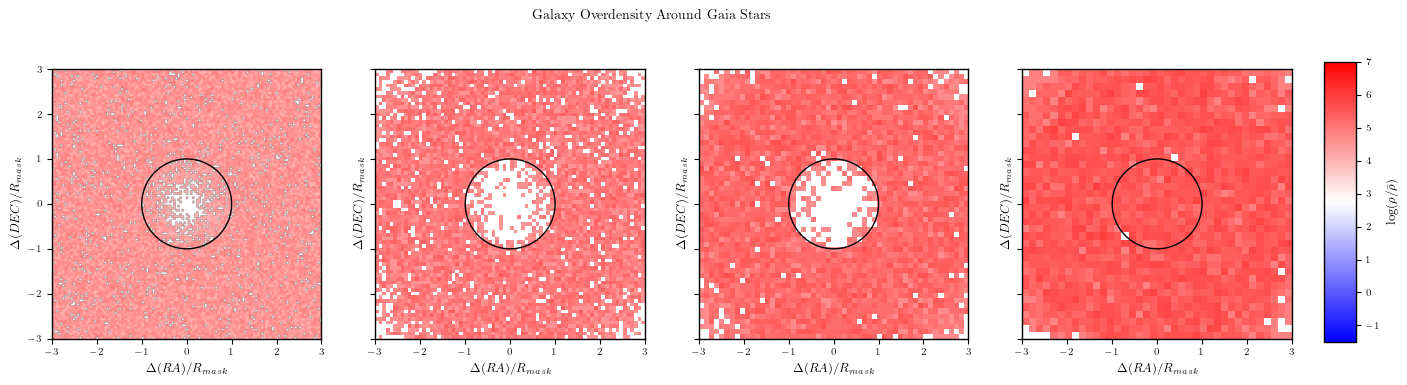

In [53]:
# Plot the results
analyzer.plot_results(vmin=-1.5, vmax=7.0)

In [58]:
# Define magnitude bins for the analysis
mag_bins = [(8, 12), (12, 13), (13, 14), (14, 15)]

# Instantiate the analyzer
analyzer = GalaxyOverdensity(
    gaia_df=gaia,
    galaxy_df=BG,
    mag_bins=mag_bins,
    sky_area_deg2=6000,
    pixel_resolution=1.0,  # Use a coarser resolution for faster demo
    search_box_factor=10.0,
    geometry='spherical',
    scaled_coords=True
)

In [59]:
# Run the full analysis pipeline
analyzer.run_analysis()

G-range  N_stars    Mean_G  Mean_Rmask_arcsec  N_pairs
   8-12   235538 10.929283          22.376265  4867442
  12-13   278465 12.557497          12.408906   398923
  13-14   539242 13.553211           8.901642   396836
  14-15   992526 14.547947           6.387921   375115


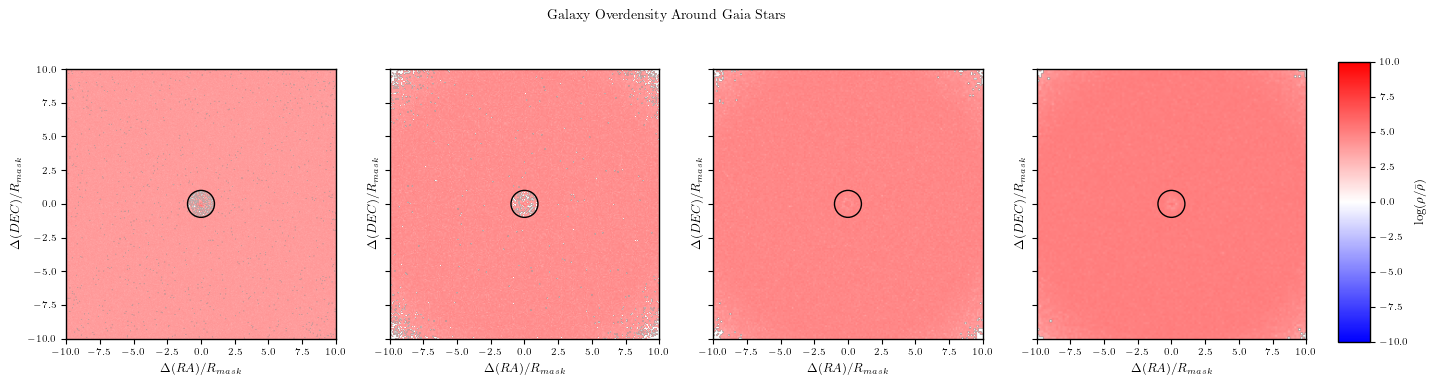

In [62]:
analyzer.plot_results(vmin=-10, vmax=10.0)

In [ ]:
BG_densities = {}
LRG_densities = {}

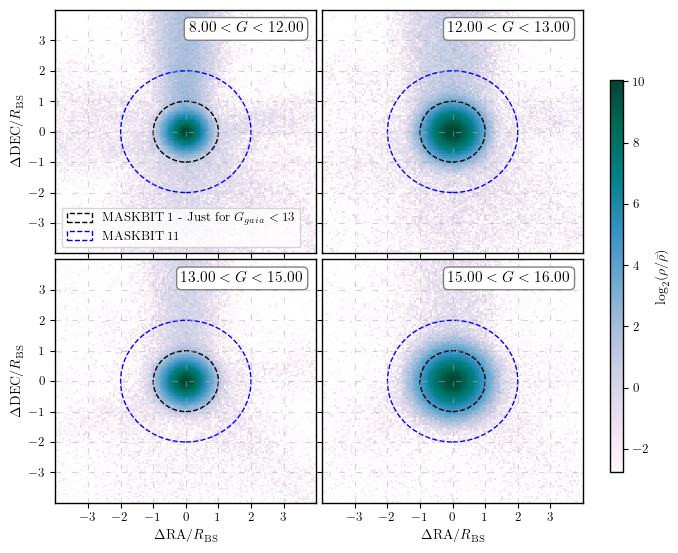

In [ ]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.01, wspace=0.01)

axes = axes.flatten()

i = 0
for mag_bin in mag_bins:
    BG_densities[mag_bin] = {}
    ax = axes[i]
    # # 2. Select “bright” stars (e.g. G ≤ 13) and turn into SkyCoords
    # bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    # stars = SkyCoord(ra=bright['RA'].values * u.deg,
    #                 dec=bright['DEC'].values * u.deg)

    # 3. Make a SkyCoord for your BG objects
    cats  = SkyCoord(ra=BG['RA'].values * u.deg,
                    dec=BG['DEC'].values * u.deg)

    bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    stars  = SkyCoord(ra=bright['RA'].values*u.deg,
                      dec=bright['DEC'].values*u.deg)

    # match & compute offsets
    idx, _, _     = cats.match_to_catalog_sky(stars)
    ra_bg, dec_bg = cats.ra.rad, cats.dec.rad
    ra_st, dec_st = stars[idx].ra.rad, stars[idx].dec.rad
    dRAc = (ra_bg - ra_st)*np.cos(dec_st)
    dDec = dec_bg - dec_st

    # compute DR9 mask‐radii and scale
    mags_at_idx = bright['G'].values[idx]
    R9_arcsec   = mask_radius_DR9(mags_at_idx)
    R_BS = 0.5 * 1630. * 1.396**(-bright['G'].values[idx])
    R_BS_max = max(R_BS)

    x = dRAc * 3600.0 / R_BS
    y = dDec * 3600.0 / R_BS

    # 8. Make a 2D histogram of (x,y)
    # nbins = 200
    H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-4,4],[-4,4]])
    #  how to turn that into a density *ratio* η/η̄ ?
    #  – compute the mean density in an annulus 1.1<R<4:
    Xc, Yc = 0.5*(xe[:-1]+xe[1:]), 0.5*(ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)
    mask = (R>annulus[0]) & (R<annulus[1])
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean
    BG_densities[mag_bin] = {
        'R9_arcsec': R9_arcsec,
        'R_BS': R_BS,
        'R_BS_max': R_BS_max,
        'x': x,
        'y': y,
        'H': H,
        'xe': xe,
        'ye': ye,
        'Xc': Xc,
        'Yc': Yc,
        'XX': XX,
        'YY': YY,
        'R': R,
        'eta_mean': eta_mean,
        'density_ratio': density_ratio,
        'mag_bin': mag_bin,
        'nbins': nbins,
        'r_extent': r_extent,
        'annulus': annulus,
        'dr': dr
    }
    # 9. Plot
    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T,
                        cmap='PuBuGn')


    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    mask_radius_lable = [r'MASKBIT 1 - Just for $G_{gaia}<13$', 'MASKBIT 11']
    for rad, col in [(1,'k'), (2,'b')]:
        circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
        ax.add_patch(circ)
    ax.text(
        0.95, 0.95,
        fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        fontsize=BIGGER_SIZE,
        bbox=dict(
            facecolor='white',
            alpha=1,
            edgecolor='gray',
            boxstyle='round,pad=0.3'
        )
    )
    
    ax.set_xticks(np.arange(-3, 4, 1))
    ax.set_yticks(np.arange(-3, 4, 1))
    ax.grid(linestyle= (0, (5, 10)), alpha=0.5)
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    # ax.axhline(0, color='k', lw=1)
    # ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[2].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[0].legend(loc='lower left')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(pcm, cax=cax, label=r'$\log_2(\rho/\bar\rho)$')

plt.tight_layout(rect=[0,0,0.9,1], h_pad=0.1, w_pad=0.1)
# plt.savefig('gaia_mask_BG.png', dpi=450, bbox_inches='tight')
# plt.savefig('gaia_mask_BG.pdf', dpi=450, bbox_inches='tight')
plt.show()



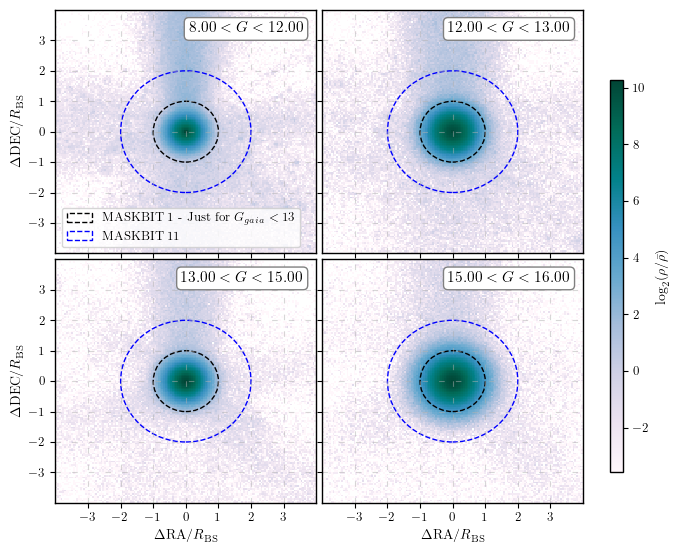

In [59]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.01, wspace=0.01)

axes = axes.flatten()

i = 0
for mag_bin in mag_bins:
    ax = axes[i]
    LRG_densities[mag_bin] = {}

    # # 2. Select “bright” stars (e.g. G ≤ 13) and turn into SkyCoords
    # bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    # stars = SkyCoord(ra=bright['RA'].values * u.deg,
    #                 dec=bright['DEC'].values * u.deg)

    # 3. Make a SkyCoord for your BG objects
    cats  = SkyCoord(ra=LRG['RA'].values * u.deg,
                    dec=LRG['DEC'].values * u.deg)

    bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    stars  = SkyCoord(ra=bright['RA'].values*u.deg,
                      dec=bright['DEC'].values*u.deg)

    # match & compute offsets
    idx, _, _     = cats.match_to_catalog_sky(stars)
    ra_bg, dec_bg = cats.ra.rad, cats.dec.rad
    ra_st, dec_st = stars[idx].ra.rad, stars[idx].dec.rad
    dRAc = (ra_bg - ra_st)*np.cos(dec_st)
    dDec = dec_bg - dec_st

    # compute DR9 mask‐radii and scale
    mags_at_idx = bright['G'].values[idx]
    R9_arcsec   = mask_radius_DR9(mags_at_idx)
    R_BS = 0.5 * 1630. * 1.396**(-bright['G'].values[idx])
    R_BS_max = max(R_BS)

    x = dRAc * 3600.0 / R_BS
    y = dDec * 3600.0 / R_BS

    # 8. Make a 2D histogram of (x,y)
    # nbins = 200
    H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-4,4],[-4,4]])
    #  how to turn that into a density *ratio* η/η̄ ?
    #  – compute the mean density in an annulus 1.1<R<4:
    Xc, Yc = 0.5*(xe[:-1]+xe[1:]), 0.5*(ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)
    mask = (R>annulus[0]) & (R<annulus[1])
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean

    LRG_densities[mag_bin] = {
        'R9_arcsec': R9_arcsec,
        'R_BS': R_BS,
        'R_BS_max': R_BS_max,
        'x': x,
        'y': y,
        'H': H,
        'xe': xe,
        'ye': ye,
        'Xc': Xc,
        'Yc': Yc,
        'XX': XX,
        'YY': YY,
        'R': R,
        'eta_mean': eta_mean,
        'density_ratio': density_ratio,
        'nbins': nbins,
        'r_extent': r_extent,
        'annulus': annulus,
        'dr': dr
    }
    # 9. Plot
    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T,
                        cmap='PuBuGn')


    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    mask_radius_lable = [r'MASKBIT 1 - Just for $G_{gaia}<13$', 'MASKBIT 11']
    for rad, col in [(1,'k'), (2,'b')]:
        circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
        ax.add_patch(circ)
    ax.text(
        0.95, 0.95,
        fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        fontsize=BIGGER_SIZE,
        bbox=dict(
            facecolor='white',
            alpha=1,
            edgecolor='gray',
            boxstyle='round,pad=0.3'
        )
    )
    
    ax.set_xticks(np.arange(-3, 4, 1))
    ax.set_yticks(np.arange(-3, 4, 1))
    ax.grid(linestyle= (0, (5, 10)), alpha=0.5)
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    # ax.axhline(0, color='k', lw=1)
    # ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[2].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[0].legend(loc='lower left')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(pcm, cax=cax, label=r'$\log_2(\rho/\bar\rho)$')

plt.tight_layout(rect=[0,0,0.9,1], h_pad=0.1, w_pad=0.1)
# plt.savefig('gaia_mask_BG.png', dpi=450, bbox_inches='tight')
# plt.savefig('gaia_mask_BG.pdf', dpi=450, bbox_inches='tight')
plt.show()



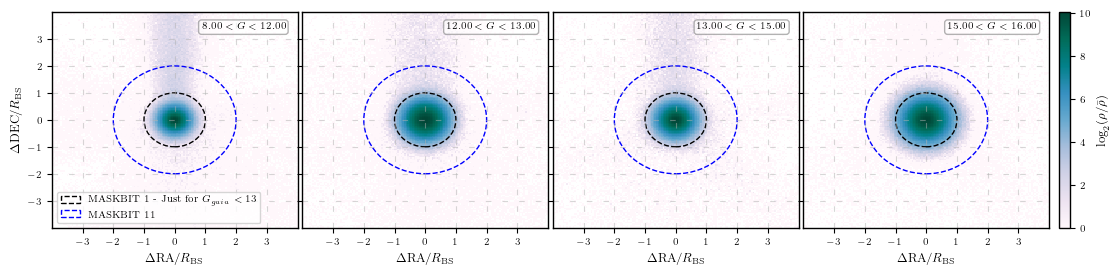

In [ ]:
nrows = 1
ncols = 4
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.02, wspace=0.02)

axes = axes.flatten()

i = 0
for mag_bin in mag_bins:
    ax = axes[i]
    # # 2. Select “bright” stars (e.g. G ≤ 13) and turn into SkyCoords
    # bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    # stars = SkyCoord(ra=bright['RA'].values * u.deg,
    #                 dec=bright['DEC'].values * u.deg)

    # 3. Make a SkyCoord for your BG objects
    cats  = SkyCoord(ra=BG['RA'].values * u.deg,
                    dec=BG['DEC'].values * u.deg)

    bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    stars  = SkyCoord(ra=bright['RA'].values*u.deg,
                      dec=bright['DEC'].values*u.deg)

    # match & compute offsets
    idx, _, _     = cats.match_to_catalog_sky(stars)
    ra_bg, dec_bg = cats.ra.rad, cats.dec.rad
    ra_st, dec_st = stars[idx].ra.rad, stars[idx].dec.rad
    dRAc = (ra_bg - ra_st)*np.cos(dec_st)
    dDec = dec_bg - dec_st

    # compute DR9 mask‐radii and scale
    mags_at_idx = bright['G'].values[idx]
    R9_arcsec   = mask_radius_DR9(mags_at_idx)
    R_BS = 0.5 * 1630. * 1.396**(-bright['G'].values[idx])
    R_BS_max = max(R_BS)

    x = dRAc * 3600.0 / R_BS
    y = dDec * 3600.0 / R_BS

    # 8. Make a 2D histogram of (x,y)
    # nbins = 200
    H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-4,4],[-4,4]])
    #  how to turn that into a density *ratio* η/η̄ ?
    #  – compute the mean density in an annulus 1.1<R<4:
    Xc, Yc = 0.5*(xe[:-1]+xe[1:]), 0.5*(ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)
    mask = (R>annulus[0]) & (R<annulus[1])
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean

    # 9. Plot
    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T,
                        cmap='PuBuGn', vmin=0)


    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    mask_radius_lable = [r'MASKBIT 1 - Just for $G_{gaia}<13$', 'MASKBIT 11']
    for rad, col in [(1,'k'), (2,'b')]:
        circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
        ax.add_patch(circ)
    ax.text(
        0.95, 0.95,
        fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(
            facecolor='white',
            alpha=0.6,
            edgecolor='gray',
            boxstyle='round,pad=0.3'
        )
    )
    ax.set_xticks(np.arange(-3, 4, 1))
    ax.set_yticks(np.arange(-3, 4, 1))
    ax.grid(linestyle= (0, (5, 10)), alpha=0.5)
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    # ax.axhline(0, color='k', lw=1)
    # ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[0].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[1].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[0].legend(loc='lower left')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')
cbar = fig.colorbar(pcm, ax=axes, fraction=0.025, pad=0.01)
cbar.set_label(r'$\log_2(\rho/\bar\rho)$')
# cbar.ax.tick_params(labelsize=MEDIUM_SIZE)
# plt.tight_layout(rect=[0,0,0.9,1])
# plt.savefig('gaia_mask_BG_4x1.png', dpi=400, bbox_inches='tight')
plt.savefig('gaia_mask_BG_4x1.pdf', dpi=400, bbox_inches='tight')


plt.show()



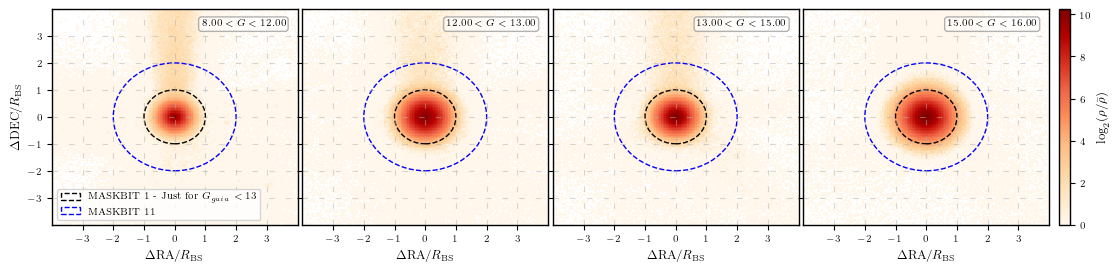

In [97]:
nrows = 1
ncols = 4
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.02, wspace=0.02)

axes = axes.flatten()

i = 0
for mag_bin in mag_bins:
    ax = axes[i]
    # # 2. Select “bright” stars (e.g. G ≤ 13) and turn into SkyCoords
    # bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    # stars = SkyCoord(ra=bright['RA'].values * u.deg,
    #                 dec=bright['DEC'].values * u.deg)

    # 3. Make a SkyCoord for your BG objects
    cats  = SkyCoord(ra=LRG['RA'].values * u.deg,
                    dec=LRG['DEC'].values * u.deg)

    bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
    stars  = SkyCoord(ra=bright['RA'].values*u.deg,
                      dec=bright['DEC'].values*u.deg)

    # match & compute offsets
    idx, _, _     = cats.match_to_catalog_sky(stars)
    ra_bg, dec_bg = cats.ra.rad, cats.dec.rad
    ra_st, dec_st = stars[idx].ra.rad, stars[idx].dec.rad
    dRAc = (ra_bg - ra_st)*np.cos(dec_st)
    dDec = dec_bg - dec_st

    # compute DR9 mask‐radii and scale
    mags_at_idx = bright['G'].values[idx]
    R9_arcsec   = mask_radius_DR9(mags_at_idx)
    R_BS = 0.5 * 1630. * 1.396**(-bright['G'].values[idx])
    R_BS_max = max(R_BS)

    x = dRAc * 3600.0 / R_BS
    y = dDec * 3600.0 / R_BS

    # 8. Make a 2D histogram of (x,y)
    # nbins = 200
    H, xe, ye = np.histogram2d(x, y, bins=nbins, range=[[-4,4],[-4,4]])
    #  how to turn that into a density *ratio* η/η̄ ?
    #  – compute the mean density in an annulus 1.1<R<4:
    Xc, Yc = 0.5*(xe[:-1]+xe[1:]), 0.5*(ye[:-1]+ye[1:])
    XX, YY = np.meshgrid(Xc,Yc)
    R = np.sqrt(XX**2 + YY**2)
    mask = (R>annulus[0]) & (R<annulus[1])
    eta_mean = H[mask].mean()
    density_ratio = H / eta_mean

    # 9. Plot
    # fig, ax = plt.subplots(figsize=(6,6))
    pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T,
                        cmap='OrRd', vmin=0)


    # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
    mask_radius_lable = [r'MASKBIT 1 - Just for $G_{gaia}<13$', 'MASKBIT 11']
    for rad, col in [(1,'k'), (2,'b')]:
        circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
        ax.add_patch(circ)
    ax.text(
        0.95, 0.95,
        fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(
            facecolor='white',
            alpha=0.6,
            edgecolor='gray',
            boxstyle='round,pad=0.3'
        )
    )
    ax.set_xticks(np.arange(-3, 4, 1))
    ax.set_yticks(np.arange(-3, 4, 1))
    ax.grid(linestyle= (0, (5, 10)), alpha=0.5)
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    # ax.axhline(0, color='k', lw=1)
    # ax.axvline(0, color='k', lw=1)
    # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
    # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
    # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
    i += 1
    
axes[0].set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
axes[0].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[1].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[0].legend(loc='lower left')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')
cbar = fig.colorbar(pcm, ax=axes, fraction=0.025, pad=0.01)
cbar.set_label(r'$\log_2(\rho/\bar\rho)$')
# cbar.ax.tick_params(labelsize=MEDIUM_SIZE)
# plt.tight_layout(rect=[0,0,0.9,1])
plt.savefig('gaia_mask_LRG_4x1.png', dpi=400, bbox_inches='tight')
plt.savefig('gaia_mask_LRG_4x1.pdf', dpi=400, bbox_inches='tight')


plt.show()



In [98]:
tracers = ['BG', 'LRG']

In [99]:
densities = [BG_densities, LRG_densities]

In [100]:
color_map = ['PuBuGn', 'OrRd']

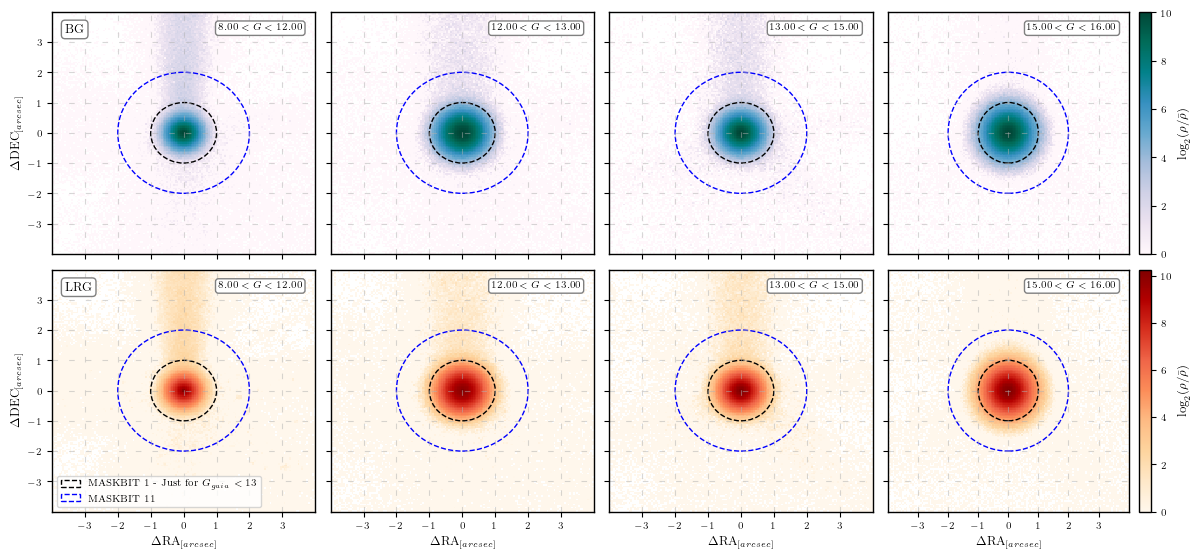

In [101]:
nrows = 2
ncols = 4
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, num=2, figsize=(sub_width*ncols, sub_height*nrows))
fig.subplots_adjust(hspace=0.02, wspace=0.02)

axes = axes.flatten()

for i, tracer in enumerate(tracers):
    for imag, mag_bin in enumerate(mag_bins):
        ax = axes[imag+i*len(mag_bins)]
        # # 2. Select “bright” stars (e.g. G ≤ 13) and turn into SkyCoords
        # bright = gaia[(gaia['G'] <= mag_bin[1]) & (gaia['G'] > mag_bin[0])]
        # stars = SkyCoord(ra=bright['RA'].values * u.deg,
        #                 dec=bright['DEC'].values * u.deg)

        # 3. Make a SkyCoord for your BG objects
        tracer = tracers[i]
        tracer_density = densities[i][mag_bin]

        R_BS = tracer_density['R_BS']
        x = tracer_density['x']
        y = tracer_density['y']

        H, xe, ye = tracer_density['H'], tracer_density['xe'], tracer_density['ye']
        Xc, Yc = tracer_density['Xc'], tracer_density['Yc']
        XX, YY = tracer_density['XX'], tracer_density['YY']
        R = np.sqrt(XX**2 + YY**2)
        mask = (R > annulus[0]) & (R < annulus[1])
        eta_mean = tracer_density['eta_mean']
        density_ratio = tracer_density['density_ratio']
        pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T, cmap=color_map[i])
        ax.grid(linestyle=(0, (5, 10)), alpha=0.5)
        ax.set_xlim(-60, 60)
        ax.set_ylim(-60, 60)
        if imag == 0:
            ax.text(
            0.05, 0.95, tracer,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            fontsize=MEDIUM_SIZE,
            bbox=dict(
                facecolor='white',
                alpha=1,
                edgecolor='gray',
                boxstyle='round,pad=0.3'
            )
        )

        # 9. Plot
        # fig, ax = plt.subplots(figsize=(6,6))
        pcm = ax.pcolormesh(xe, ye, np.log2(density_ratio).T,
                            cmap=color_map[i], vmin=0)


        # 10. Overplot the DR9 mask circle (R=1) and DR8 mask (R≈2)
        mask_radius_lable = [r'MASKBIT 1 - Just for $G_{gaia}<13$', 'MASKBIT 11']
        for rad, col in [(1,'k'), (2,'b')]:
            circ = Circle((0,0), radius=rad, fill=False, ls='--', lw=1, ec=col, label=mask_radius_lable[rad-1])
            ax.add_patch(circ)
        ax.text(
            0.95, 0.95,
            fr"${mag_bin[0]:4.2f}<G<{mag_bin[1]:4.2f}$",
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(
                facecolor='white',
                alpha=1,
                edgecolor='gray',
                boxstyle='round,pad=0.3'
                )
            )

        ax.set_xticks(np.arange(-3, 4, 1))
        ax.set_yticks(np.arange(-3, 4, 1))
        ax.grid(linestyle= (0, (5, 10)), alpha=0.5)
        ax.set_xlim(-4,4)
        ax.set_ylim(-4,4)
        # ax.axhline(0, color='k', lw=1)
        # ax.axvline(0, color='k', lw=1)
        # ax.set_title(f'G mag: {mag_bin[0]} - {mag_bin[1]}')
        # ax.set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
        # ax.set_ylabel(r'$\Delta\mathrm{DEC}/R_{\rm BS}$')
        if imag == 3:
            cbar = fig.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label(r'$\log_2(\rho/\bar\rho)$')
        
        if imag == 0:
            ax.set_ylabel(r'$\Delta\mathrm{DEC}_{[arc sec]}$')

        if i == 1:
            ax.set_xlabel(r'$\Delta\mathrm{RA}_{[arc sec]}$')
# axes[0].set_xlabel(r'$\Delta\mathrm{RA}_{[arc sec]}$')

# axes[0].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# axes[1].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# axes[2].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# axes[3].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
axes[4].legend(loc='lower left')
# axes[5].set_xlabel(r'$\Delta\mathrm{RA}/R_{\rm BS}$')
# cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
# fig.colorbar(pcm, cax=cax, label=r'$\log_2(\eta/\bar\eta)$')

# cbar.ax.tick_params(labelsize=MEDIUM_SIZE)
plt.tight_layout(rect=[0,0,0.9,1])
plt.savefig('gaia_mask_Both_4x2.png', dpi=400, bbox_inches='tight')
plt.savefig('gaia_mask_Both_4x2.pdf', dpi=400, bbox_inches='tight')


plt.show()



In [88]:
import pickle

In [89]:
with open('gaia_mask_BG_densities.pkl', 'wb') as f:
    pickle.dump(BG_densities, f)
with open('gaia_mask_LRG_densities.pkl', 'wb') as f:
    pickle.dump(LRG_densities, f)